# Importing Necessary Libraries

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import random
import tensorflow as tf
import scipy as sp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report

# 1. Data Preprocessing:
- Standardize image sizes and normalize pixel values.
- Apply augmentation techniques to increase data diversity.

In [123]:
train_path = 'F:/Lab6 Dataset/train_cancer'

train = ImageDataGenerator(rescale=1/255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,brightness_range=[1.0,2.0],rotation_range=20,validation_split=0.2)
train_generator = train.flow_from_directory(train_path,target_size=(224, 224),batch_size=32,class_mode='categorical',subset='training')
test_generator = train.flow_from_directory(train_path,target_size=(224,224),batch_size=32,class_mode = 'categorical',subset='validation',shuffle=True)
print("Class indices:")
print(train_generator.class_indices)

Found 216 images belonging to 2 classes.
Found 54 images belonging to 2 classes.
Class indices:
{'benign': 0, 'malignant': 1}


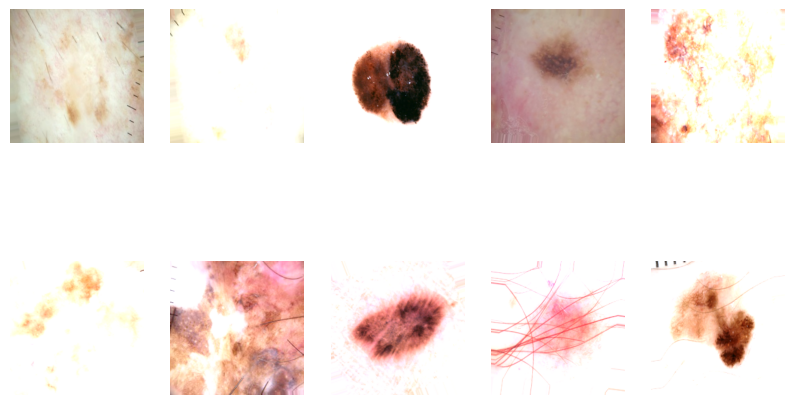

In [124]:
#Visualize some of the augmented images
x_batch, y_batch = next(train_generator)
fig, axs = plt.subplots(2, 5,figsize=(10,6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(x_batch[i])
    ax.axis('off')
plt.show()

# 2. Model Architectures:
-VGG16 or VGG19

In [125]:
from tensorflow.keras.applications import VGG16
model_vgg16 = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')

In [126]:
for layer in model_vgg16.layers:
   layer.trainable=False
   model_vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,712,896 (56.13 MB)

 Non-trainable params: 1,792 (7.00 KB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,675,968 (55.98 MB)

 Non-trainable params: 38,720 (151.25 KB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,675,968 (55.98 MB)

 Non-trainable params: 38,720 (151.25 KB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,602,112 (55.70 MB)

 Non-trainable params: 112,576 (439.75 KB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,454,528 (55.14 MB)

 Non-trainable params: 260,160 (1016.25 KB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,454,528 (55.14 MB)

 Non-trainable params: 260,160 (1016.25 KB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,159,360 (54.01 MB)

 Non-trainable params: 555,328 (2.12 MB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 13,569,280 (51.76 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 11,799,040 (45.01 MB)

 Non-trainable params: 2,915,648 (11.12 MB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 9,439,232 (36.01 MB)

 Non-trainable params: 5,275,456 (20.12 MB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 2,359,808 (9.00 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)        │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [127]:
model = Sequential()
model.add(model_vgg16)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ vgg16 (Functional)                 │ ?                             │  14,714,688 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten_14 (Flatten)               │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_28 (Dense)                   │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_14 (Dropout)               │ ?                             │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_29 (Dense)                   │ ?                             │ 0 (unbuilt) │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

# 3. Training:
- Split the dataset into training, validation, and test sets.
- For VGG models, employ transfer learning by initializing with pre-trained ImageNet weights and fine-tuning only the fully connected layers.

In [128]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5


C:\Users\DELL\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 83s 11s/step - accuracy: 0.6690 - loss: 4.2678 - val_accuracy: 0.8889 - val_loss: 5.5142
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - accuracy: 0.8498 - loss: 4.5864 - val_accuracy: 0.7407 - val_loss: 0.5630
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 85s 12s/step - accuracy: 0.8377 - loss: 0.8222 - val_accuracy: 0.8889 - val_loss: 0.8750
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 104s 15s/step - accuracy: 0.8483 - loss: 0.8524 - val_accuracy: 0.8889 - val_loss: 0.5113
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 87s 12s/step - accuracy: 0.8344 - loss: 0.5314 - val_accuracy: 0.8889 - val_loss: 0.2983


# 4. Evaluation:
- Evaluate the trained models on the test set.
- Calculate metrics including accuracy, precision, recall, and F1-score.
- Visualize model predictions and analyze misclassifications.

In [129]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 6s/step - accuracy: 0.8738 - loss: 0.4522
Test Accuracy: 0.8888888955116272


It's benign


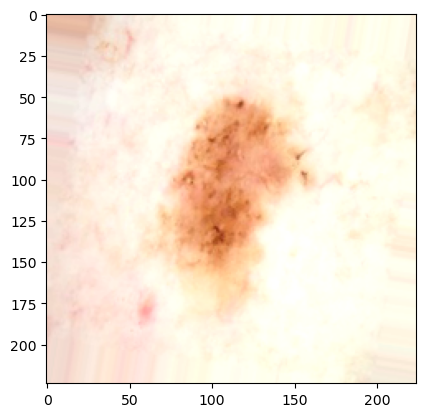

In [130]:
x_batch, y_batch = next(test_generator)
list = [*range(1, 10, 1)]
a = random.choice(list)
plt.imshow(x_batch[a])
pred = test_generator.labels[a]
if pred == 0:
  print("It's benign")
elif pred == 1:
  print("It's malignant")

In [131]:
y_pred = np.argmax(model.predict(test_generator), axis=-1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 7s/step


In [132]:
classes = dict(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))
Predictions = pd.DataFrame({"Test Labels" : test_generator.labels,
                            "Test Classes" : [classes[i] for i in test_generator.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_generator.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_generator), axis = 1))]})

2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 8s/step


In [133]:
Predictions.sample(10)

,Test Labels,Test Classes,Prediction Labels,Prediction Classes,Path,Prediction Probability
38,1,malignant,1,malignant,malignant\131.jpg,0.996915
34,1,malignant,1,malignant,malignant\126.jpg,0.998804
2,0,benign,1,malignant,benign\14.jpg,0.997874
22,1,malignant,1,malignant,malignant\115.jpg,0.996746
13,1,malignant,1,malignant,malignant\106.jpg,0.997617
41,1,malignant,1,malignant,malignant\134.jpg,0.997416
35,1,malignant,1,malignant,malignant\127.jpg,0.999341
12,1,malignant,1,malignant,malignant\105.jpg,0.997817
37,1,malignant,1,malignant,malignant\130.jpg,0.999670
4,0,benign,1,malignant,benign\19.jpg,0.999712


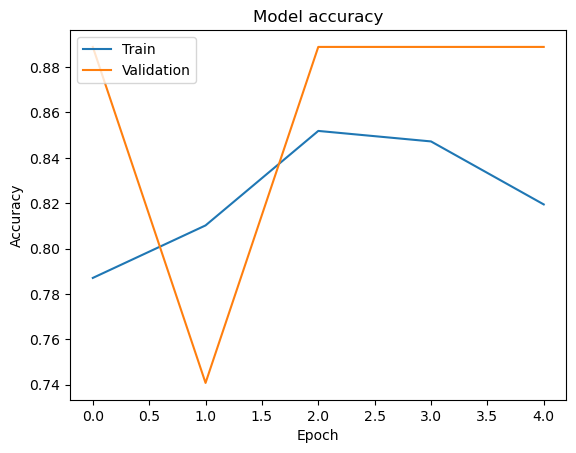

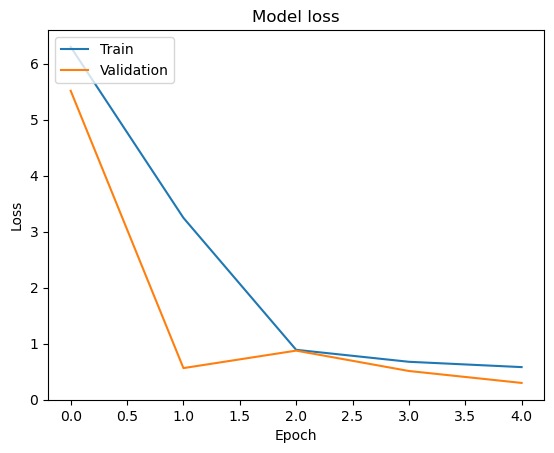

In [134]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

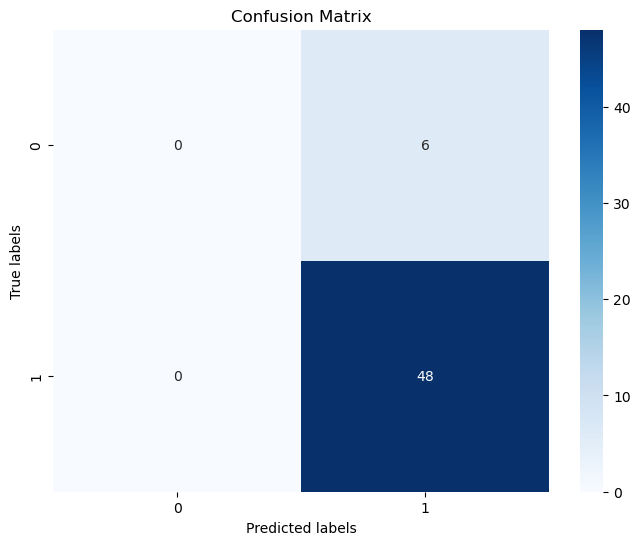

In [135]:
y_true = test_generator.classes
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [136]:
print(classification_report(y_true,y_pred,zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.89      1.00      0.94        48

    accuracy                           0.89        54
   macro avg       0.44      0.50      0.47        54
weighted avg       0.79      0.89      0.84        54



# 2. Model Architectures:
- Custom CNN: Designed specifically for skin cancer detection, this model comprises:
- Four convolutional layers with increasing filter sizes (32, 64, 128, 256) and ReLU activation.
- Max pooling layers after each convolutional layer.
- Two dense layers with 512 neurons each, followed by a dropout layer (dropout rate: 0.5).
- Output layer with 1 neuron and sigmoid activation for binary classification.

In [137]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(2, activation='sigmoid'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

C:\Users\DELL\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                 │ (None, 222, 222, 32)          │         896 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_28 (MaxPooling2D)    │ (None, 111, 111, 32)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_29 (Conv2D)                 │ (None, 109, 109, 64)          │      18,496 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_29 (MaxPooling2D)    │ (None, 54, 54, 64)            │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_30 (Conv2D)                 │ (None, 52, 52, 128)           │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_30 (MaxPooling2D)    │ (None, 26, 26, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_31 (Conv2D)                 │ (None, 24, 24, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_31 (MaxPooling2D)    │ (None, 12, 12, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten_15 (Flatten)               │ (None, 36864)                 │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_30 (Dense)                   │ (None, 512)                   │  18,874,880 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_15 (Dropout)               │ (None, 512)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_31 (Dense)                   │ (None, 2)                     │       1,026 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 19,264,322 (73.49 MB)

 Trainable params: 19,264,322 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

# 3. Training:
- Train the custom CNN model from scratch.
- Use appropriate optimization algorithms (e.g., SGD, Adam) and monitor performance on the validation set for early stopping.

In [138]:
history = model1.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7925 - loss: 0.7767 - val_accuracy: 0.8889 - val_loss: 0.4401
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8755 - loss: 0.4496 - val_accuracy: 0.8889 - val_loss: 0.3310
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9020 - loss: 0.3191 - val_accuracy: 0.8889 - val_loss: 0.3350
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8745 - loss: 0.4390 - val_accuracy: 0.8889 - val_loss: 0.3023
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8868 - loss: 0.3422 - val_accuracy: 0.8889 - val_loss: 0.3023


# 4. Evaluation:
- Evaluate the trained models on the test set.
- Calculate metrics including accuracy, precision, recall, and F1-score.
- Visualize model predictions and analyze misclassifications. 

In [139]:
test_loss, test_accuracy = model1.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 531ms/step - accuracy: 0.9051 - loss: 0.3084
Test Accuracy: 0.8888888955116272


In [140]:
y_preds = np.argmax(model1.predict(test_generator), axis=-1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 626ms/step


In [141]:
classes = dict(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))
Predictions = pd.DataFrame({"Test Labels" : test_generator.labels,
                            "Test Classes" : [classes[i] for i in test_generator.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_preds],
                            "Path": test_generator.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_generator), axis = 1))]})
Predictions.sample(10)

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step


,Test Labels,Test Classes,Prediction Labels,Prediction Classes,Path,Prediction Probability
0,0,benign,1,malignant,benign\12.jpg,0.999898
41,1,malignant,1,malignant,malignant\134.jpg,0.999984
29,1,malignant,1,malignant,malignant\121.jpg,0.990699
7,1,malignant,1,malignant,malignant\100.jpg,0.996793
37,1,malignant,1,malignant,malignant\130.jpg,0.995444
46,1,malignant,1,malignant,malignant\14.jpg,0.997936
39,1,malignant,1,malignant,malignant\132.jpg,0.997095
42,1,malignant,1,malignant,malignant\135.jpg,0.994334
47,1,malignant,1,malignant,malignant\140.jpg,0.999983
18,1,malignant,1,malignant,malignant\111.jpg,0.990524


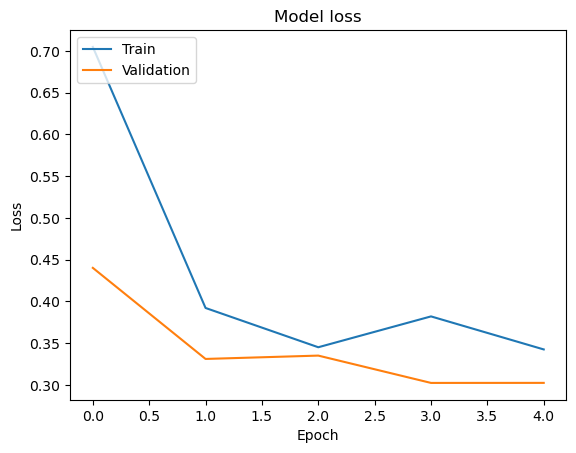

In [142]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

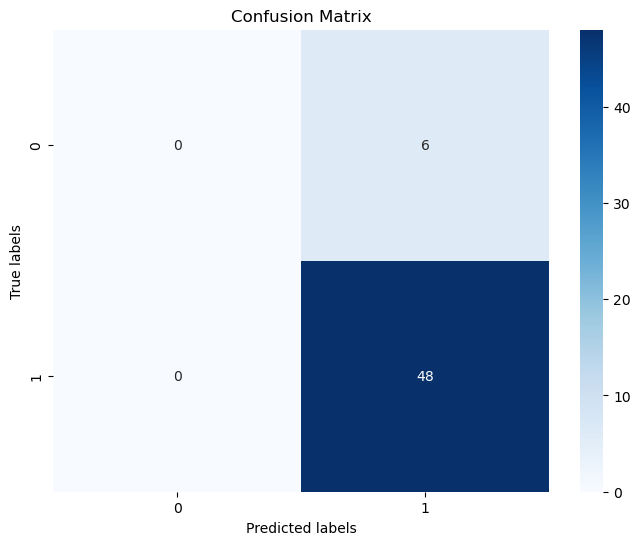

In [143]:
y_true = test_generator.classes
conf_matrix = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [144]:
print(classification_report(y_true,y_preds,zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.89      1.00      0.94        48

    accuracy                           0.89        54
   macro avg       0.44      0.50      0.47        54
weighted avg       0.79      0.89      0.84        54



# 4.Comparison:
● Visualize loss and accuracy curves during training for both architectures to analyze
convergence patterns.
● Compare traditional metrics (accuracy, precision, recall, F1-score,ROC-AUC, specificity)
between VGG and custom CNN models.
● Present ROC curves and confusion matrices to compare classification performance and
error patterns.

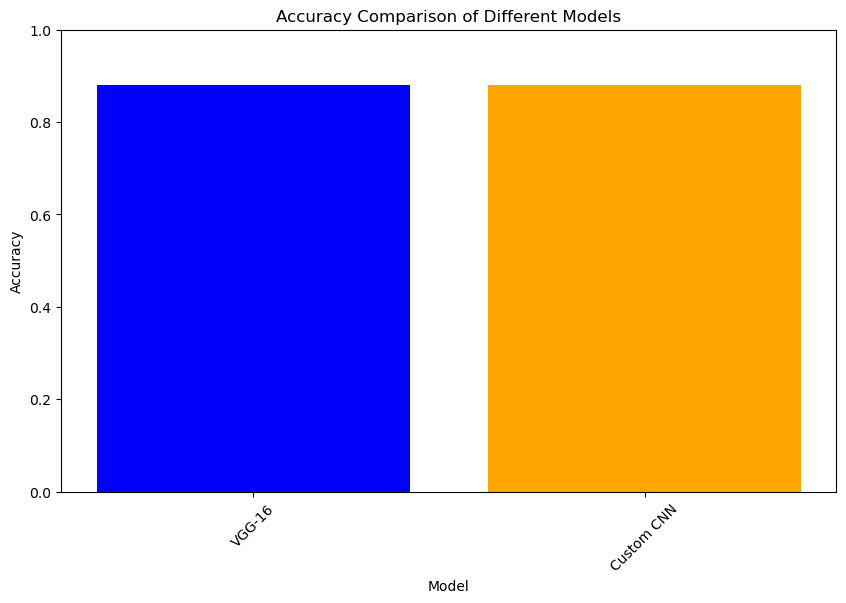

In [145]:
accuracies = {'VGG-16': 0.88,'Custom CNN': 0.88}

# Plot accuracies
plt.figure(figsize=(10, 6))
bars = plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'orange'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()